In [50]:
import pandas as pd
#data = pd.read_csv('C:\Bee Temp Data\C265_w_Env.csv') #For control hive
data = pd.read_csv('C:\Bee Temp Data\C284_w_Env.csv') #For treated hive -> only non-treated days
data = data[:10*24] #first seven days of data

In [51]:
import numpy as np
from lmfit import minimize, Parameters, Parameter, report_fit
import scipy.integrate as scint
import matplotlib.pyplot as plt

def bee_eq(y, t, theta_E, solar_rad, theta, k_W, x_W, k_M):
    theta_W =  y
    dydt = (theta_E - theta_W)*k_W + x_W*k_W*solar_rad - k_M*(theta_W - theta)
    return dydt

def run_bee_eq(t, a, theta_E, solar_rad, hive_temp, k_W, x_W, k_M):
    sol = scint.odeint(bee_eq, a, t, args=(theta_E, solar_rad, hive_temp, k_W, x_W, k_M), col_deriv = True, rtol = 10e-3, atol = 10e-3) #w' and 'amplitude_temp_ext'
    theta_t = sol[-1,:]
    return theta_t    

def residual(ps, ts, data):
    data_group = data.groupby('Date')
    k_M = ps['k_M'].value #lumped thermal conductivity hive core
    x_W = ps['x_W'].value
    k_W = 0.29 #ps['k_W'].value
    model = []
    for i,j in data_group:
        environment_temp = j['Air Temp'].values 
        solar_radiation = j['Sol Rad'].values
        hive_temp = j['Temp'].values
        
        t_max = len(environment_temp)-1
        t = np.linspace(0,t_max, num = t_max+1)
        a = [1]*len(environment_temp)
        fitted_temp = run_bee_eq(t, a, environment_temp, solar_radiation, hive_temp, k_W, x_W, k_M)
        
        model = np.concatenate((model, fitted_temp))
    
    return (model - data['Temp_Easy']).ravel()

params = Parameters()
params.add('k_M', value = 1, min = 0, max = np.inf)
params.add('x_W', value = 0.005, min = 0.000001, max = np.inf)
#params.add('k_W', value = 1, min = 0.000001, max = 1)
t_max = len(data)-1
t = np.linspace(0,t_max, num = t_max+1)
#result = minimize(residual, params, args=(t, data),method='brute',nan_policy='omit', Ns = 20)
result = minimize(residual, params, args=(t, data),method='nelder',nan_policy='omit')
sig_min_front = data['Temp_Easy'] + result.residual[:len(data['Temp_Easy'])].reshape(data['Temp_Easy'].shape)
print('k_M', result.params['k_M'].value)
print('x_W', result.params['x_W'].value)
#print('k_W', result.params['k_W'].value)

k_M 0.7463796922691659
x_W 0.013809373948100556


In [52]:
import pandas as pd
import numpy as np
from lmfit import minimize, Parameters
import scipy.integrate as scint
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d

In [53]:
def bee_eq(y, t, w1,w2, env_temp,h, solar, k_W, k_A_W, k_hive, eta_W, 
           eta_A_W, eta_B_W, theta_ideal, P_C):
    hive_temp = y
    M = -h*(w1*w2*(1-np.exp(-hive_temp+theta_ideal)) / (w2+w1*np.exp(-hive_temp+theta_ideal)))
    W = 4*(k_W + k_hive)*(-hive_temp + env_temp) + 4*eta_W*solar 
    A_W = (k_A_W + k_hive)*(-hive_temp + env_temp) + eta_A_W*solar
    B_W = (k_W + k_hive)*(-hive_temp + env_temp) + eta_B_W*solar
    dydt = M + W + A_W + B_W - P_C
    return dydt

def run_bee_eq(t, a, w1,w2, env_temp,h, solar, k_W, k_A_W, k_hive, eta_W, eta_A_W, eta_B_W, theta_ideal, P_C):
    sol = scint.odeint(bee_eq, a, t, args=(w1,w2, env_temp,h, solar, k_W, k_A_W, k_hive, 
                                           eta_W, eta_A_W, eta_B_W, theta_ideal, P_C), 
                                           col_deriv = True, rtol = 10e-3, atol = 10e-3)
                                           #hmin = 0.001) #w' and 'amplitude_temp_ext'
    theta_t = sol[-1,:]
    return theta_t 

In [54]:
def residual(ps, ts, data, l):
    d = pd.DataFrame(data).groupby(data['Date'])
    model = []
    k = 0
    alpha  = 1
    r_c = 124 #1011 #ps['w1'].value
    r_h = 428 #6204 #ps['w2'].value
    h_ = [1]
    return_value = []
    for m,n in d:
        h = ps['h_'+str(k)].value #health factor per day
        theta_ideal = ps['theta_'+str(k)].value + 273.15 #theta_ideal per day
        t_max = len(n['Air Temp'])-1
        t = np.linspace(0,t_max, num = t_max+1)
        environment_temp = n['Air Temp'].values + 273.15 #hourly environment temperature -> kelvin
        solar_rad = n['Sol Rad'].values #hourly solar radiation -> kelvin
        if n['Treatment'].values[0] == 1:
            P_C = n['P'].values
        else:
            P_C = 0
        
        a = [1]*len(environment_temp)
        
        fitted = run_bee_eq(t, a, r_c, r_h, environment_temp, h, solar_rad, k_W, k_A_W, 
                            k_hive, eta_W, eta_A_W, eta_B_W, theta_ideal, P_C)
        model = np.concatenate((model, fitted - 273.15))
        try:
            h_.append(abs(h - ps['h_'+str(k-1)].value))
        except:
            h_.append(abs(h_[k] - h))
        k = k+1
    return_value = np.concatenate((return_value, (model - data['Temp']).ravel()))
    return_value = np.concatenate((return_value, l*np.array(h_[2:]).ravel()))
    print(np.mean(abs((model - data['Temp']).ravel())))
    return return_value

In [55]:
import datetime
data = pd.read_csv('C:\Bee Temp Data\C284_w_Env.csv')

try:
    for i in range(len(data)):
        current_date = (datetime.datetime.strptime(str(data['Date'].values[i]), "%m/%d/%Y")).date()
        current_time = datetime.datetime.strptime(str(data['Time'].values[i]), "%H:%M:%S").time()
        current_datetime = datetime.datetime.combine(current_date,current_time)
        data['DateTime'][i] = datetime.datetime.strptime(str(current_datetime), "%Y-%m-%d %H:%M:%S")
        data['Date'][i] = data['DateTime'][i].date()
        data['Time'][i] = data['DateTime'][i].time()
except:
    pass


d = pd.DataFrame(data).groupby([data['Date']])
k_W = 0.29 #0.9322636905520281 #[9.974510910778044]*len(data) #thermal conductivity of wood -> per hour
eta_W = 0.014*k_W #0.0033021413705307534*k_W #[0.003307946071640233*9.974510910778044]*len(data) #heat absorption coeff of wood
k_A_W = 0.29 #0.6699726312530309 #[7.206896551724138]*len(data) #thermal conductivity of top surface (wood + aluminum plate) -> per hour
eta_A_W = 0.014*k_W #0.0021755653867763236*k_A_W #[0.0021482758620689655*7.206896551724138]*len(data) #heat absorption coeff of top surface
eta_B_W = 0.014*k_W #0.0029*k_W #[0.0029*9.974510910778044]*len(data) #heat absorption coeff of bottom surface
k_hive = 0.74 #1.07 #0.84 #[1.5540477862285431]*len(data)

In [56]:
h_max = 1
l = 96/h_max
params = Parameters()
a = 0
data['Treatment'] = 0
for i,j in d:
    params.add('h_'+str(a), value = 0.3, min = 0.1, max = h_max)
    try:
        params.add('theta_'+str(a), value = np.mean(j['Temp']), min = np.min(j['Temp']), max = np.min(j['Temp']))
    except:
        params.add('theta_'+str(a), value = np.mean(j['Temp']), min = np.min(j['Temp']) - 0.05, max = np.max(j['Temp']) + 0.05)
    a = a+1             
t_max = len(data)-1
t = np.linspace(0,t_max, num = t_max+1)

result = minimize(residual, params, args=(t,data, l), method='leastsq',nan_policy='omit')
sig_min = data['Temp'].values + result.residual[:len(data['Temp'].values)].reshape(data['Temp'].shape)

1.3062349076047184
1.3062349076047184
1.3062349076047184
1.3062349882819462
1.306234902888432
1.306234782405548
1.3062348578621361
1.3062347209337422
1.3062349008207639
1.3062347167281594
1.306234888524562
1.306234745126666
1.30623488065627
1.306234861477842
1.3062348731831224
1.3062348165539108
1.3062348671922943
1.306234809290778
1.3062348800350232
1.3062348625809843
1.306234905443383
1.3062348240144115
1.3062348821609984
1.3062355523252027
1.3062348842934888
1.3062347598491788
1.3062348768012084
1.3062348759599094
1.3062348683354978
1.306234646013037
1.3062348308137381
1.3062346243203298
1.3062348083390622
1.3062346364847501
1.3062348371416543
1.3062345665480453
1.3062348377204154
1.3062345970584242
1.306234713331975
1.3062350863697019
1.3062348401309622
1.3062347504527463
1.3062348644054762
1.306234783622873
1.3062348651196893
1.3062347415850555
1.30623490385965
1.3062347188294694
1.3062348910483446
1.3062347967703194
1.3062348695591501
1.3062348063126032
1.306234866433855
1.306234

0.6339780886510136
0.6339780282134639
0.6339779600562215
0.6339780593620206
0.6339779414516733
0.6339781183938507
0.633978057104407
0.6339780947205488
0.6339779247752159
0.6339781515017635
0.6339779759867991
0.6339780985566984
0.6339781962957166
0.6339780493063962
0.6339781416080438
0.6339780374867076
0.6339782066682297
0.6339780915213891
0.6339779086812278
0.6339781100435132
0.6339781598404173
0.6339781021383852
0.633978214983236
0.6339780991140498
0.6348382021285712
0.6335772617817962
0.6335773012602449
0.6335772895240446
0.6335770923615277
0.6335771805692388
0.6335777574240117
0.633577179638508
0.6335751821706267
0.6335773595129638
0.6335773866017352
0.6335771505142889
0.6335771847659547
0.6335771948507274
0.6335771853830349
0.6335772409649253
0.6335772341944056
0.6335772202543398
0.6335771199127405
0.6335771972015561
0.6335772954440656
0.6335772417480913
0.6335745230847118
0.6335773950973828
0.6335772279273567
0.6335771924784
0.6335773446145178
0.6335772420870769
0.6335770524791148

0.6322254922484519
0.6322255694849143
0.6322256674492618
0.6322256140413263
0.6322258092302195
0.6322256248646237
0.632225600275078
0.6322255647563212
0.6322254164785606
0.6322256395835341
0.6322254506969075
0.6322256310465765
0.6322258937490908
0.6322256758200027
0.6322259022361336
0.6322256766657107
0.6322253341442879
0.6322256343905596
0.6322261654491773
0.6322256631450504
0.6322213433380292
0.6322259343961455
0.6322257334933602
0.632225600580775
0.6322262320998652
0.6322254990152322
0.6322254949454207
0.6322255944358005
0.6322253419779186
0.6322256648371519
0.6322255954528495
0.632225629491315
0.6322246161361872
0.6322256441047271
0.6322253952950454
0.632225634068006
0.6322258110455413
0.6322255813976938
0.6322256692365575
0.6322255724851908
0.6322259136969747
0.6322256183185379
0.6322255269297264
0.6322256414624796
0.6322256194788096
0.632225634459855
0.6322257636817156
0.6322256341225959
0.6325219673323459
0.6322234790338757
0.6322235185465702
0.6322235067292313
0.632223253152740

In [57]:
data['Recons_P'] = sig_min

h = np.array([])
theta = np.array([])
a = 0
for i in range(len(d)):
    h = np.concatenate((h, np.array([result.params['h_'+str(a)].value]*24)))
    theta = np.concatenate((theta, np.array([result.params['theta_'+str(a)]]*24)))
    a = a+1
data['h_P'] = h
data['theta_P'] = theta

In [58]:
data.to_csv('C:\Bee Temp Data\C284_w_Env.csv')

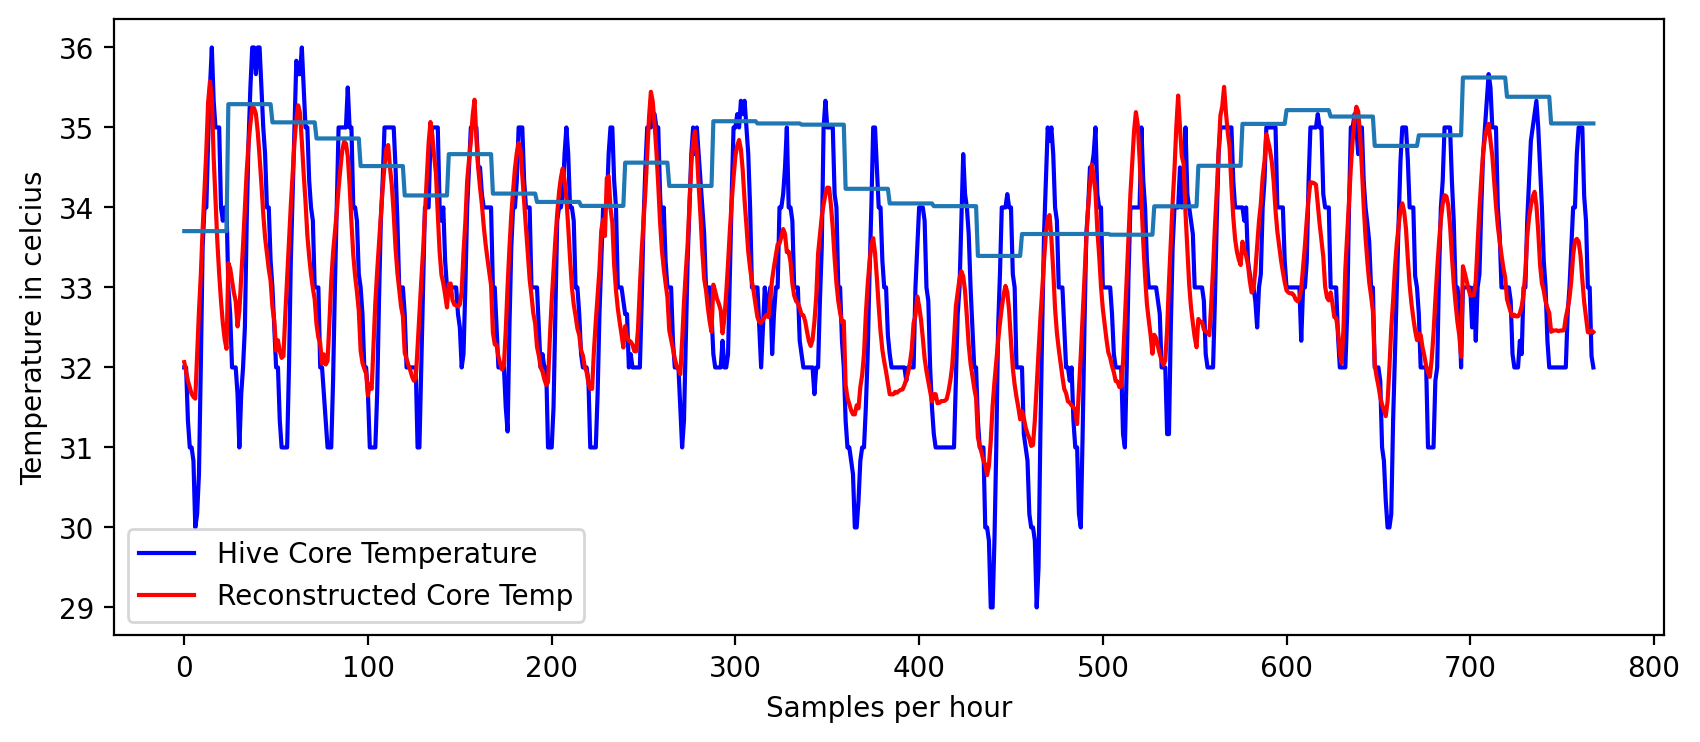

In [59]:
plt.figure(figsize = (10,4), dpi = 200)
plt.plot(data['Temp'], label = 'Hive Core Temperature', color = 'blue')
plt.plot(sig_min, label = 'Reconstructed Core Temp', color = 'red') 
plt.plot(data['theta_P'])
plt.xlabel('Samples per hour')
plt.ylabel('Temperature in celcius')
plt.legend()
plt.show()